In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

In [2]:
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

In [3]:
# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

In [4]:
# importing train data to learn
train = pd.read_csv("god.csv", 
                    parse_dates = True, low_memory = False, index_col = 'date')

In [5]:
# time series as indexes
train.index

DatetimeIndex(['2014-12-31', '2014-12-31', '2014-12-31', '2014-12-31',
               '2014-12-31', '2014-12-31', '2014-12-31', '2014-12-31',
               '2014-12-31', '2014-12-31',
               ...
               '2013-01-25', '2013-01-25', '2013-01-25', '2013-01-25',
               '2013-01-25', '2013-01-25', '2013-01-25', '2013-01-25',
               '2013-01-25', '2013-01-25'],
              dtype='datetime64[ns]', name='date', length=753999, freq=None)

In [6]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5)

In total:  (753999, 15)


,Unnamed: 0,store_id,day_of_the_week,sales,store_status,customers,discount,holiday,competitor,brand,product,competitor_id,month_comp1,year_comp1,marketing_campaign
date,,,,,,,,,,,,,,,
2014-12-31,1,1,3,2605,1,327,0,0,1,c,a,1270,9,2008,0
2014-12-31,2,2,3,2269,1,252,0,0,1,a,a,570,11,2007,1
2014-12-31,3,3,3,3804,1,408,0,0,1,a,a,14130,12,2006,1
2014-12-31,4,4,3,10152,1,1311,0,0,1,c,c,620,9,2009,0
2014-12-31,5,5,3,1830,1,217,0,0,1,a,a,29910,4,2015,0


In [7]:
train = train.drop(columns="Unnamed: 0")

In [8]:
print("In total: ", train.shape)
train.head(5)

In total:  (753999, 14)


,store_id,day_of_the_week,sales,store_status,customers,discount,holiday,competitor,brand,product,competitor_id,month_comp1,year_comp1,marketing_campaign
date,,,,,,,,,,,,,,
2014-12-31,1,3,2605,1,327,0,0,1,c,a,1270,9,2008,0
2014-12-31,2,3,2269,1,252,0,0,1,a,a,570,11,2007,1
2014-12-31,3,3,3804,1,408,0,0,1,a,a,14130,12,2006,1
2014-12-31,4,3,10152,1,1311,0,0,1,c,c,620,9,2009,0
2014-12-31,5,3,1830,1,217,0,0,1,a,a,29910,4,2015,0


In [9]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['sale_per_customer'] = train['sales']/train['customers']
train['sale_per_customer'].describe()

count    626040.000000
mean          9.402150
std           2.168348
min           0.000000
25%           7.830688
50%           9.160014
75%          10.788473
max          64.957854
Name: sale_per_customer, dtype: float64

On average customers buy 9 items per day. Though there are days with sales equal to zero.

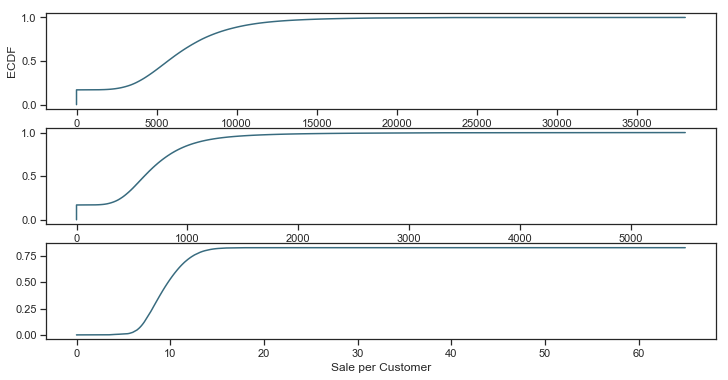

In [10]:
#ECDF: empirical cumulative distribution function
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['sale_per_customer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

About 20% of data has zero amount of sales / customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, is it only due to the fact that the store is closed?

In [11]:
# closed stores
train[(train.store_status == 0) & (train.sales == 0)].head()

,store_id,day_of_the_week,sales,store_status,customers,discount,holiday,competitor,brand,product,competitor_id,month_comp1,year_comp1,marketing_campaign,Year,Month,Day,WeekOfYear,sale_per_customer
date,,,,,,,,,,,,,,,,,,,
2014-12-28,1,7,0,0,0,0,0,1,c,a,1270,9,2008,0,2014,12,28,52,NaN
2014-12-28,2,7,0,0,0,0,0,0,a,a,570,11,2007,1,2014,12,28,52,NaN
2014-12-28,3,7,0,0,0,0,0,0,a,a,14130,12,2006,1,2014,12,28,52,NaN
2014-12-28,4,7,0,0,0,0,0,0,c,c,620,9,2009,0,2014,12,28,52,NaN
2014-12-28,5,7,0,0,0,0,0,0,a,a,29910,4,2015,0,2014,12,28,52,NaN


In [12]:
# opened stores with zero sales
zero_sales = train[(train.store_status != 0) & (train.sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (49, 19)


,store_id,day_of_the_week,sales,store_status,customers,discount,holiday,competitor,brand,product,competitor_id,month_comp1,year_comp1,marketing_campaign,Year,Month,Day,WeekOfYear,sale_per_customer
date,,,,,,,,,,,,,,,,,,,
2014-10-01,708,3,0,1,0,1,0,0,c,c,11470,10,2009,1,2014,10,1,40,NaN
2014-09-22,357,1,0,1,0,0,0,0,a,a,2060,10,2008,0,2014,9,22,39,NaN
2014-09-11,227,4,0,1,0,0,0,0,a,a,2370,0,0,0,2014,9,11,37,NaN
2014-09-11,835,4,0,1,0,0,0,0,a,a,2890,12,2007,1,2014,9,11,37,NaN
2014-09-10,835,3,0,1,0,0,0,0,a,a,2890,12,2007,1,2014,9,10,37,NaN


Interestingly enough, there are opened store with no sales on working days. There're only 51 days in this data subset, so we can assume that there were external factors involved, for example manifestations or weather.

In [13]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["store_status"] != 0) & (train['sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (626038, 19)


In [14]:
# fill NaN with a 0 for competitor ID
train["competitor_id"].fillna(0, inplace=True)

In [15]:
train.groupby('brand')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
a,339408.0,6922.452202,3309.801462,46.0,4669.00,6264.0,8412.00,38025.0
b,11584.0,10131.709427,5174.995808,1252.0,6238.75,9044.0,13011.00,37403.0
c,84152.0,6925.228693,2952.974084,133.0,4866.00,6379.0,8355.25,31448.0
d,190894.0,6765.391222,2558.494519,538.0,4992.00,6335.0,8060.00,38037.0


Brand B has the highest average of sales among all others, however we have much less data for it. So let's print an overall sum of sales and customers to see which brand generates the most revenue and generates more customers:

In [22]:
train.groupby('brand')['customers', 'sales'].sum()

,customers,sales
brand,,
a,272155662,2349535657
b,23346451,117365722
c,69092719,582771845
d,115916116,1291472592


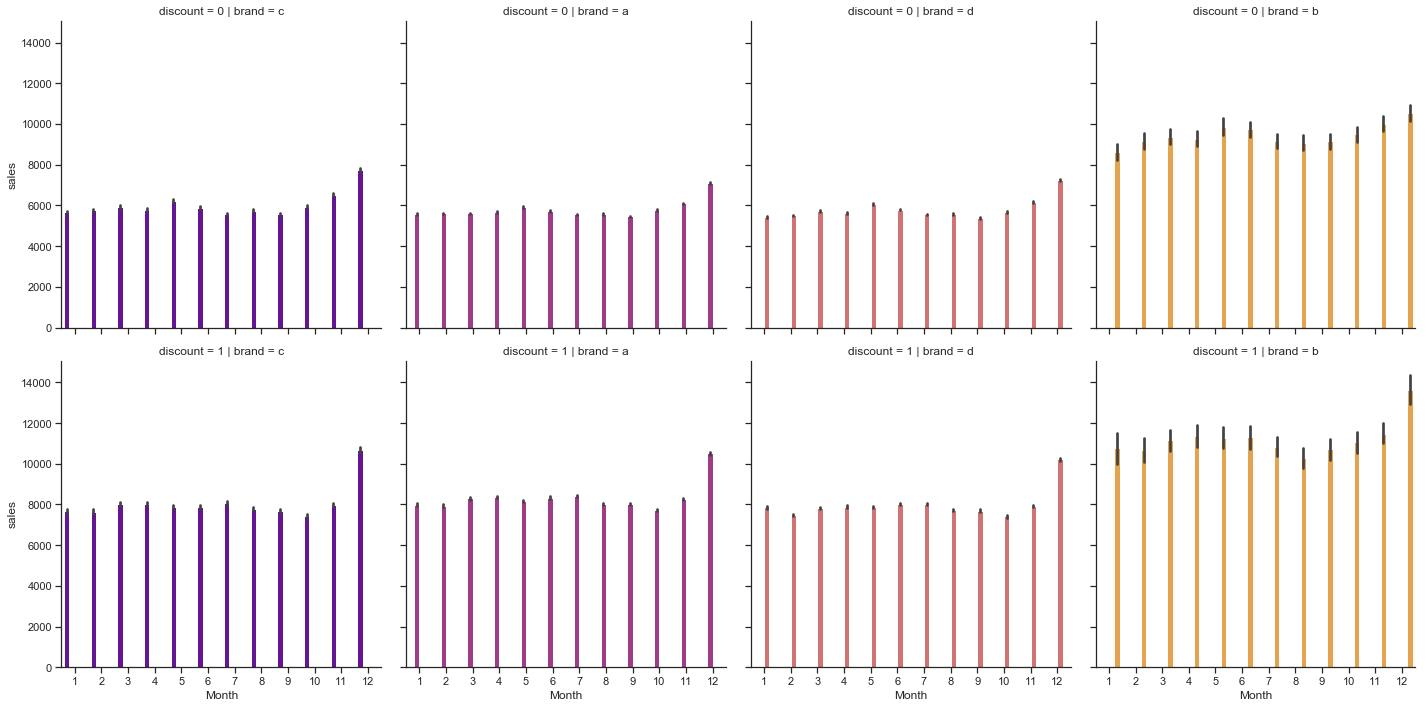

In [23]:
# sales trends
sns.catplot(data = train, x = 'Month', y = "sales", 
               col = 'brand',
               palette = 'plasma',
               hue = 'brand',
               row = 'discount',
            kind="bar",
               color = c) 

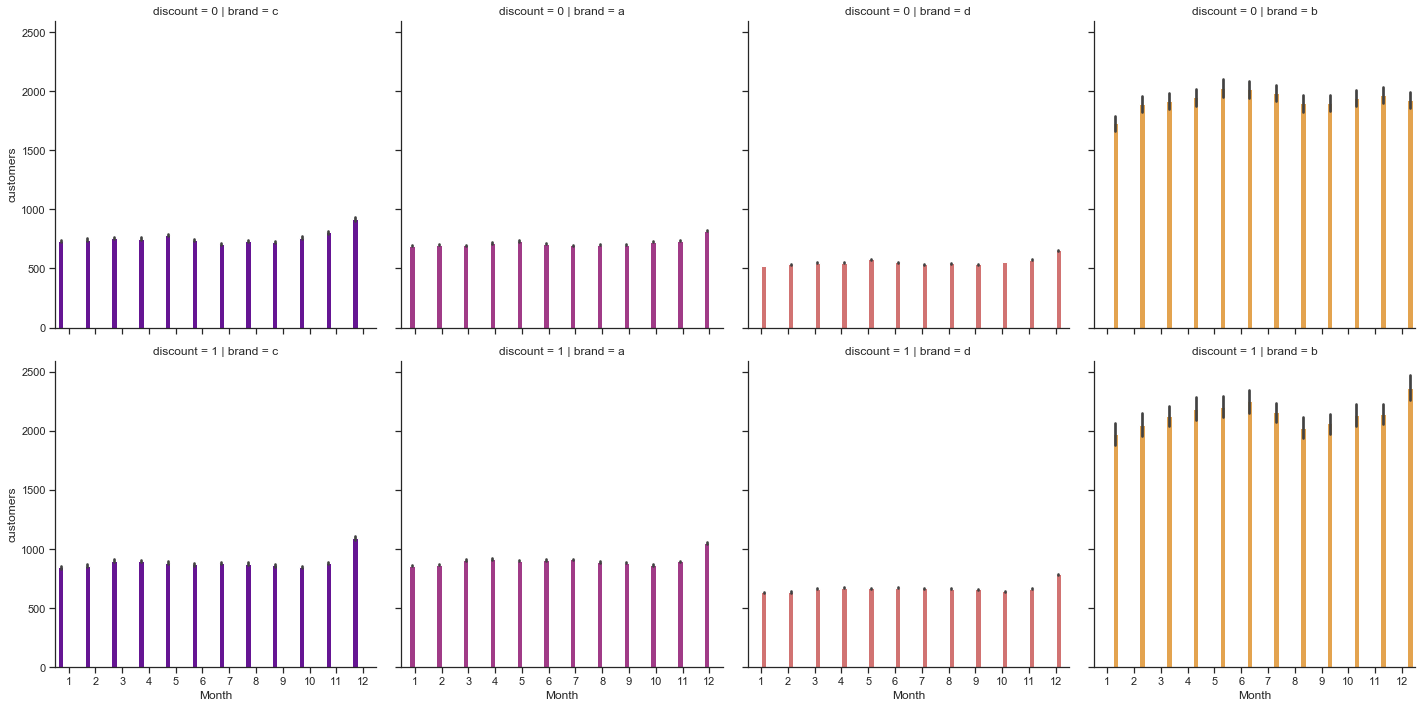

In [18]:
# sales trends
sns.catplot(data = train, x = 'Month', y = "customers", 
               col = 'brand',
               palette = 'plasma',
               hue = 'brand',
               row = 'discount',
            kind="bar",
               color = c) 

All brands follow the same trend but at different scales depending on the presence of the (first) discount and brand itself (case for B).

Already at this point, we can see that sales escalate towards Christmas holidays. But we'll talk about seasonalities and trends later in the Time Series Analysis section.

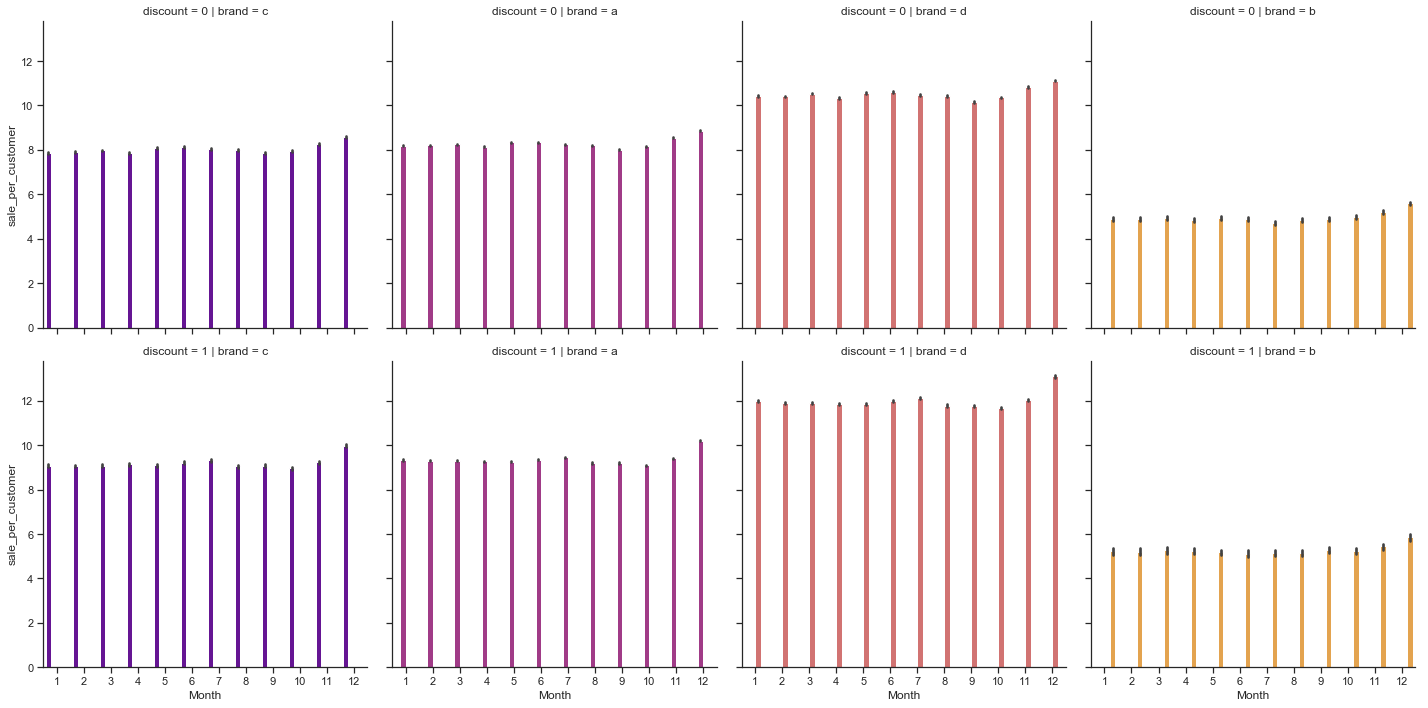

In [19]:
# sales trends
sns.catplot(data = train, x = 'Month', y = "sale_per_customer", 
               col = 'brand',
               palette = 'plasma',
               hue = 'brand',
               row = 'discount',
            kind="bar",
               color = c) 

In [28]:
train.groupby('brand')['sale_per_customer'].describe()

,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
a,339408.0,8.766339,1.662639,3.635389,7.551378,8.556126,9.802455,29.877551
b,11584.0,5.088395,1.244970,2.749075,4.001876,4.943710,6.047153,9.203528
c,84152.0,8.552863,1.691677,3.382542,7.362596,8.358804,9.543599,64.957854
d,190894.0,11.168879,1.964840,4.881279,9.784697,11.090144,12.434211,57.614983


Eventhough the plots above showed brand B as the most selling and performant one, in reality it is not true. The highest sale per customer amount is observed with brand D, about 13€ with discount and 11€ without. As for brand A and C it is about 10€ with discount.

Low revenue sale per customer amount for brand B might describe a specific population segmentation. Plus we saw that overall this brand generated the least amount of sales and customers over the period (see counts before plots).

In [20]:
train.groupby('brand')['sale_per_customer'].describe()

,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
a,351443.0,8.762240,1.662290,3.635389,7.547425,8.551092,9.798573,29.877551
b,11956.0,5.081075,1.250901,2.749075,3.992221,4.933107,6.047927,9.203528
c,87070.0,8.544198,1.689545,3.382542,7.353780,8.350210,9.533578,64.957854
d,197840.0,11.163773,1.963383,4.881279,9.780442,11.085564,12.430128,57.614983


Brand hierarchy for sale per customer: D > A > C > B

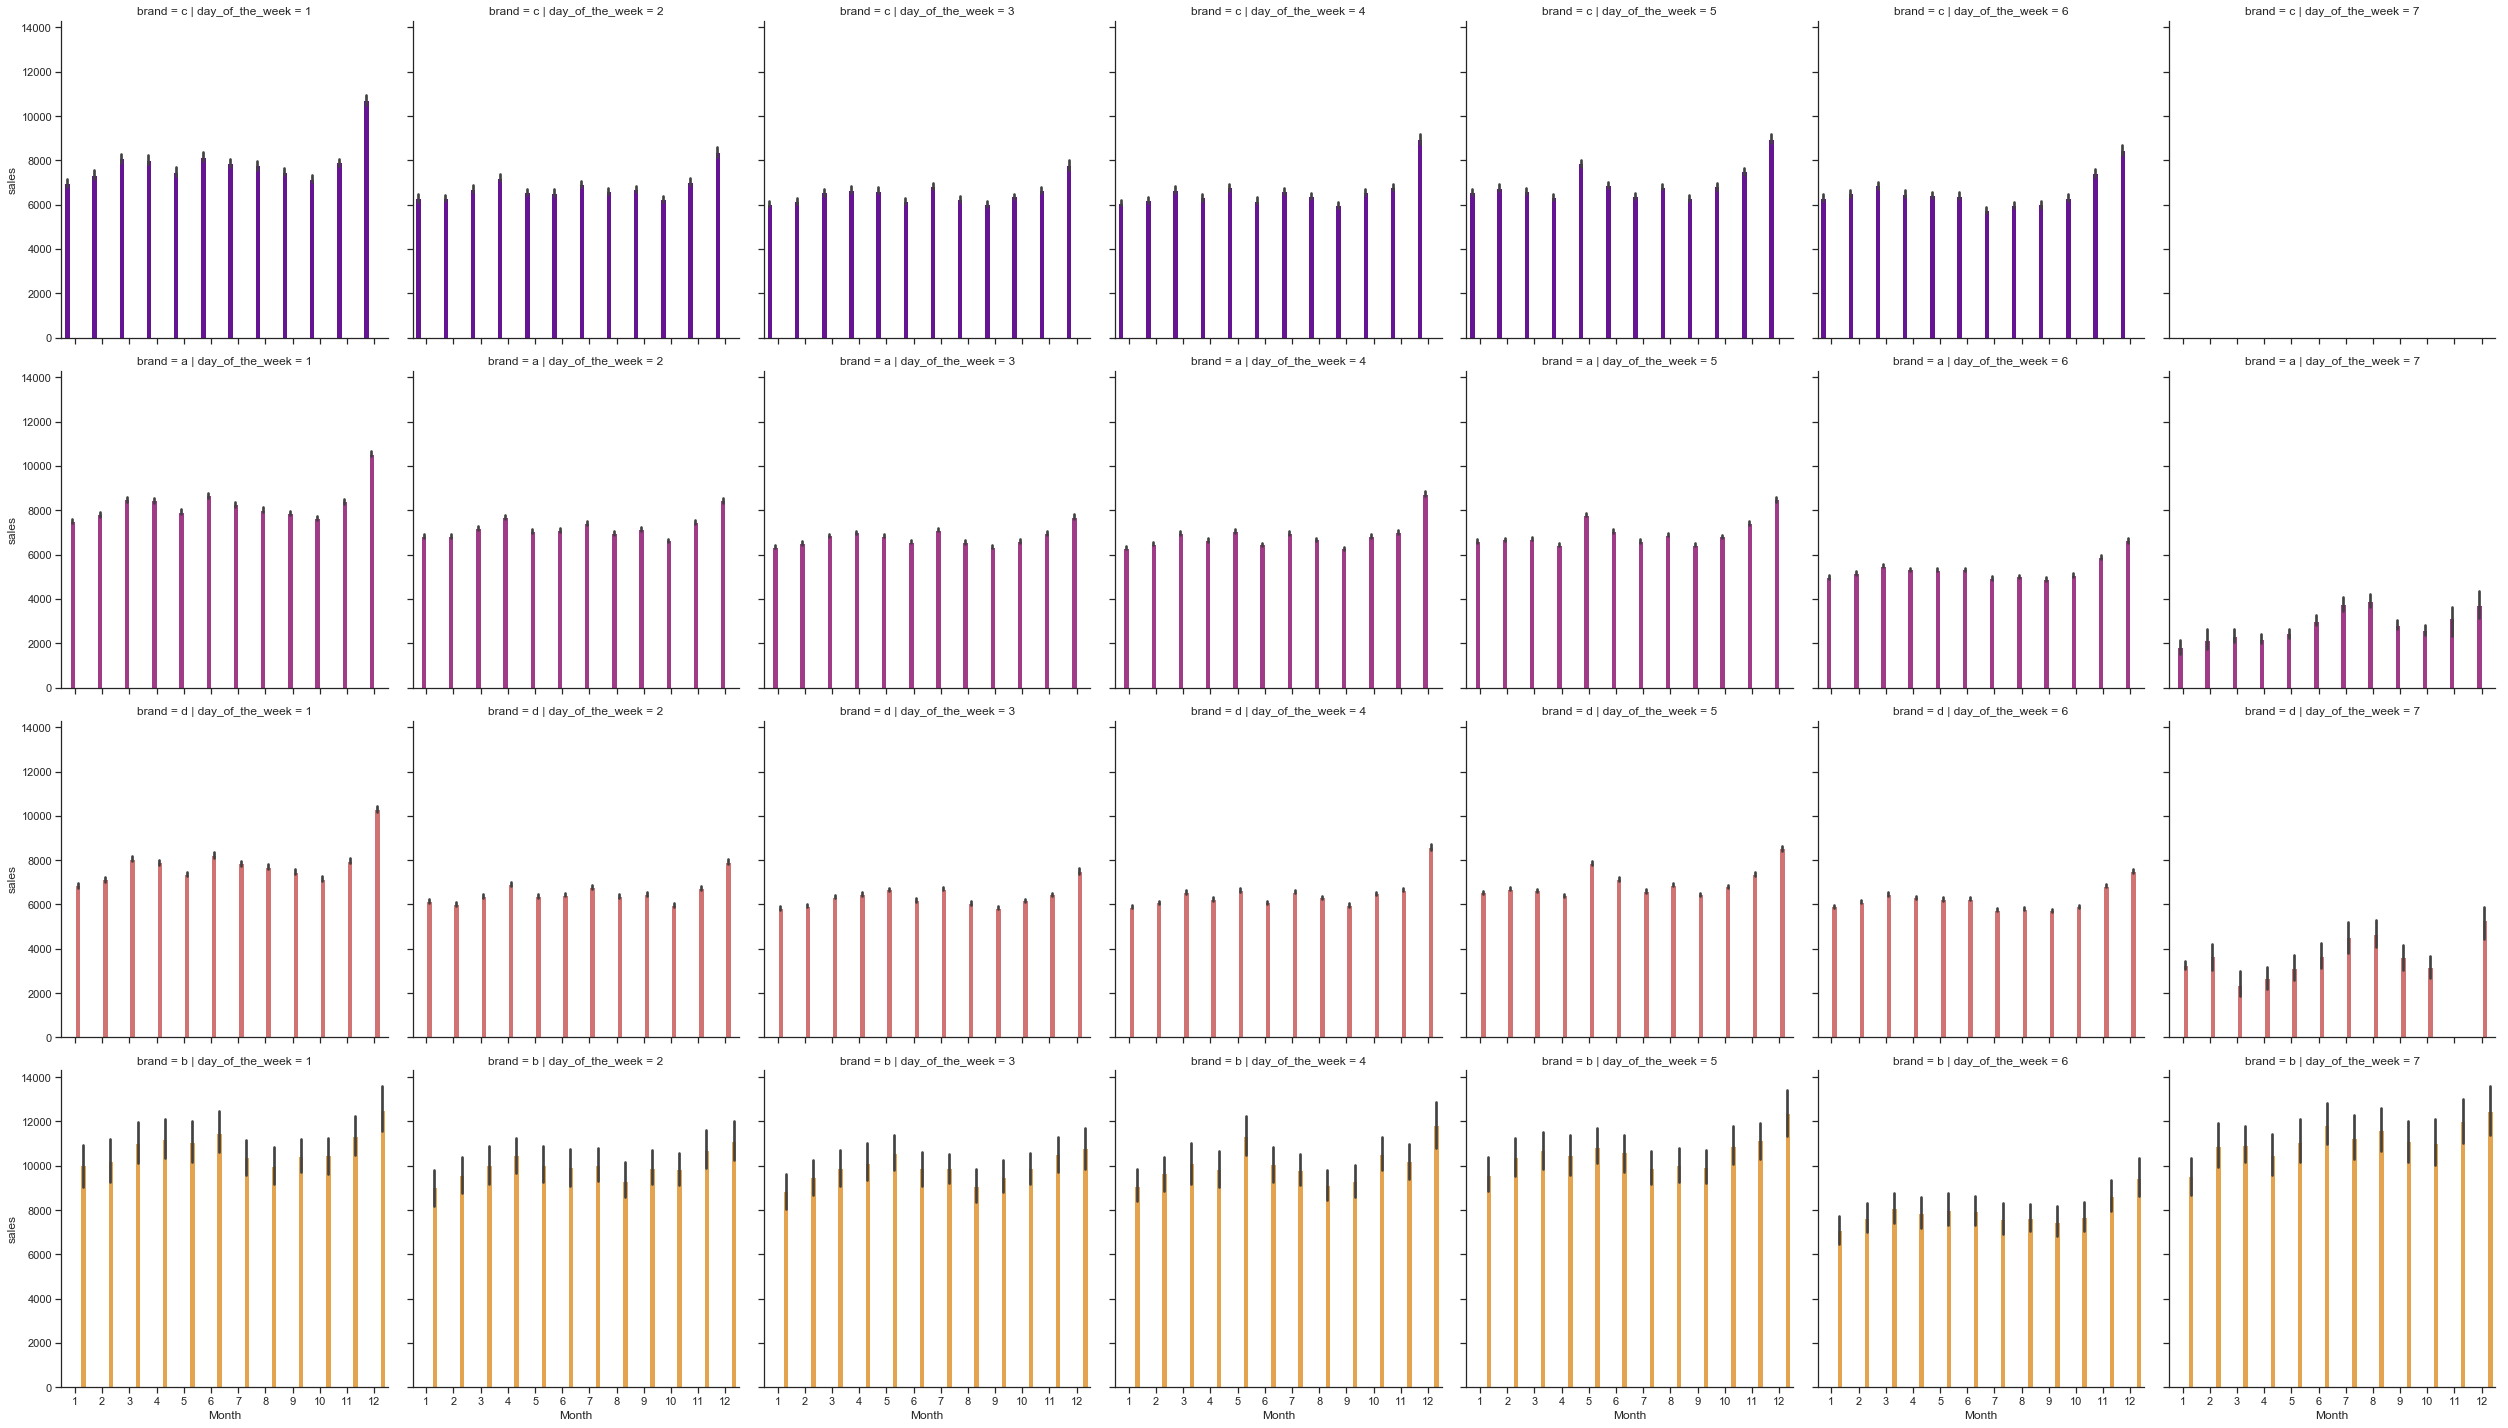

In [21]:
sns.catplot(data = train, x = 'Month', y = "sales", 
               col = "day_of_the_week",
               palette = 'plasma',
               hue = 'brand',
               row = 'brand',
            kind="bar",
               color = c) 

We see that stores selling brand C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores selling brand D are closed on Sundays only from October to December.

By the way what are the stores which are opened on Sundays?

In [22]:
# stores which are opened on Sundays
train[(train.store_status == 1) & (train.day_of_the_week == 7)]['store_id'].unique()

array([  85,  122,  259,  262,  274,  310,  335,  353,  423,  453,  494,
        530,  562,  578,  676,  682,  732,  733,  769,  948, 1081, 1097,
       1099,  209,  863,  877, 1045,  299,  524,  867,  931,  433,  512])

In [23]:
# competition open time (in months)
train['comp_time'] = 12 * (train.Year - train.year_comp1) + \
        (train.Month - train.month_comp1)

In [24]:
# replace NA's by 0
train.fillna(0, inplace = True)

In [25]:
# average CompetitionOpen time per brand type
train.loc[:, ['brand', 'sales', 'customers', 'comp_time']].groupby('brand').mean()

,sales,customers,comp_time
brand,,,
a,6908.103024,800.498872,7114.675908
b,10085.456758,2007.060890,11346.197892
c,6908.561387,819.908350,6743.378466
d,6741.641569,605.427735,9038.987237


The most selling brand A doesn't appear to be the one the most exposed to competitors. Instead it's a brand B, facing competitors

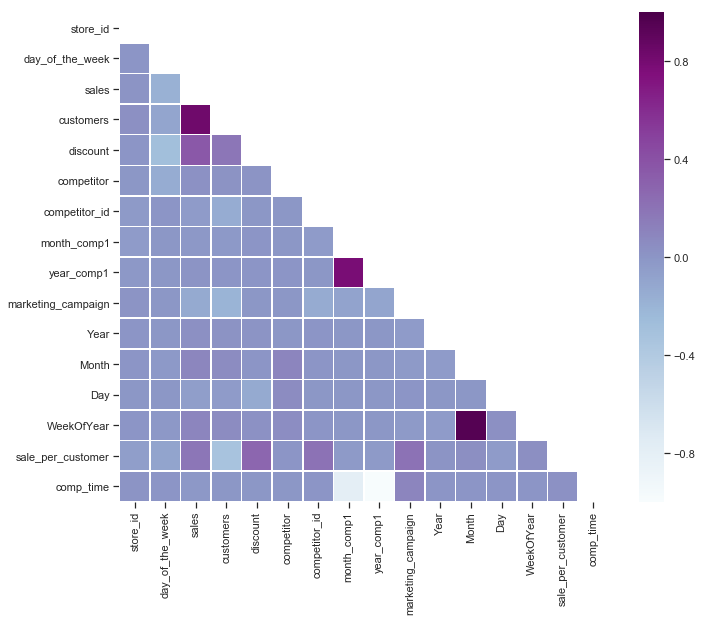

In [26]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train.drop('store_status', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

As mentioned before, we have a strong positive correlation between the sale revenue and customers of a store. We can also observe a positive correlation between the fact that the store had a running discount (discount equal to 1) and amount of Customers.

However, as soon as the store continues a marketing campaign (marketing_campaign equal to 1) the number of customers and sales seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of a discount in the store and the day of a week.

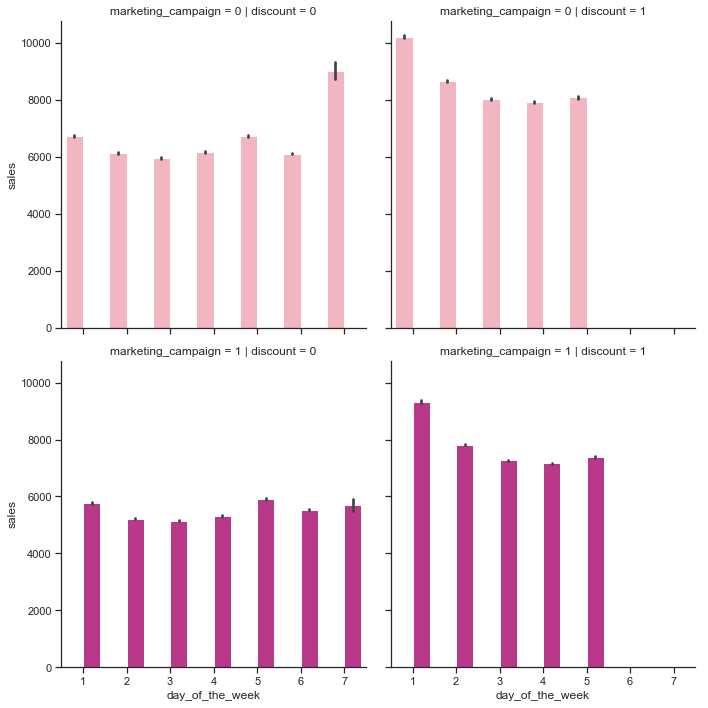

In [27]:
sns.catplot(data = train, x = 'day_of_the_week', y = "sales", 
               col = "discount",
               palette = 'RdPu',
               hue = 'marketing_campaign',
               row = 'marketing_campaign',
            kind="bar",
               color = c)

There are several things here:
<br>
<br>
In case of no discount, both discount and marketing campaign are equal to 0, sale revenue tend to peak on Sunday (!). Though we should note that brand C doesn't sell on Sundays (see previous plots). So it is mainly data from brand A, B and D.
<br>
<br>
On the contrary, stores that run the discount tend to make most of the revenue on Monday. This fact could be a good indicator for the store chain marketing campaigns. The same trend follow the stores which have both discount and marketing campaign at the same time (discount and marketing campaign are equal to 1).
<br>
<br>
Marketing campaign alone doesn't seem to be correlated to any significant change in the revenue amount. This can be also highlighted by the blue pale area on the heatmap above.

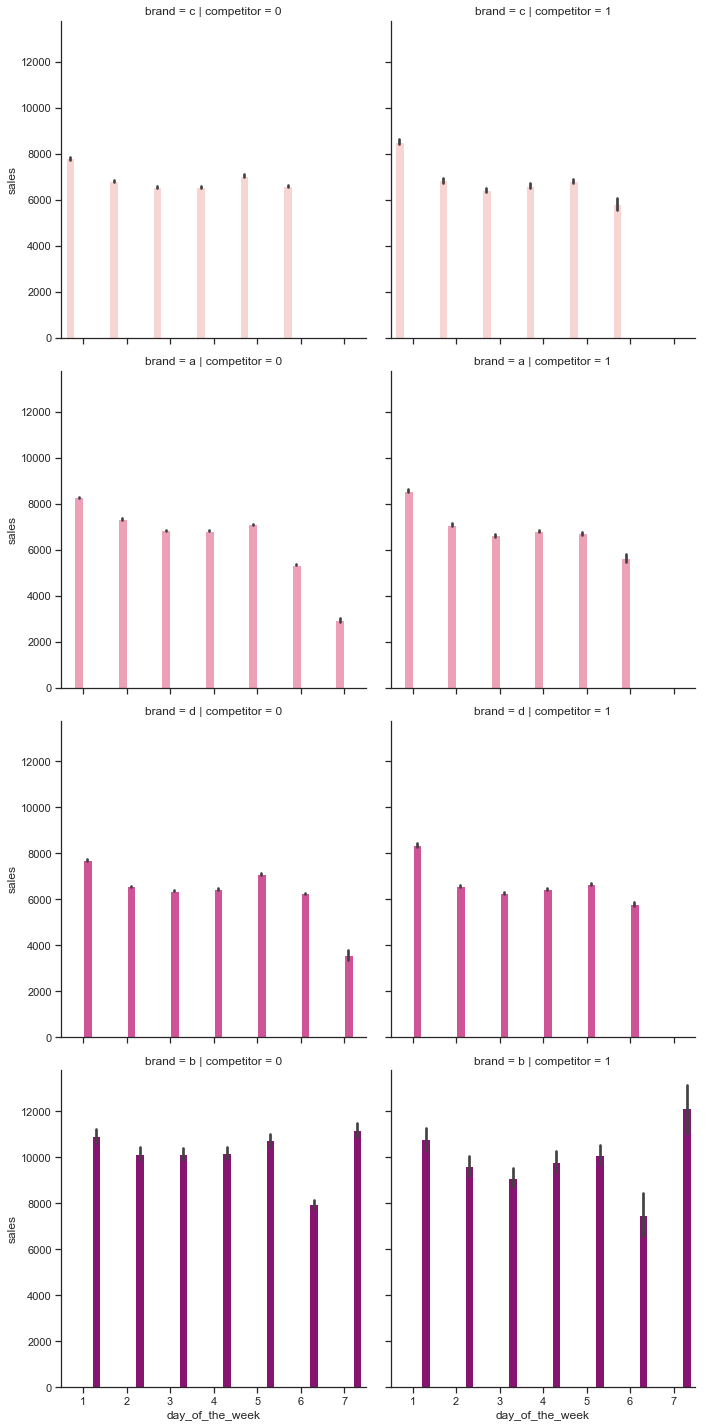

In [70]:
sns.catplot(data = train, x = 'day_of_the_week', y = "sales", 
               col = "competitor",
               palette = 'RdPu',
               hue = 'brand',
               row = 'brand',
            kind="bar",
               color = c)

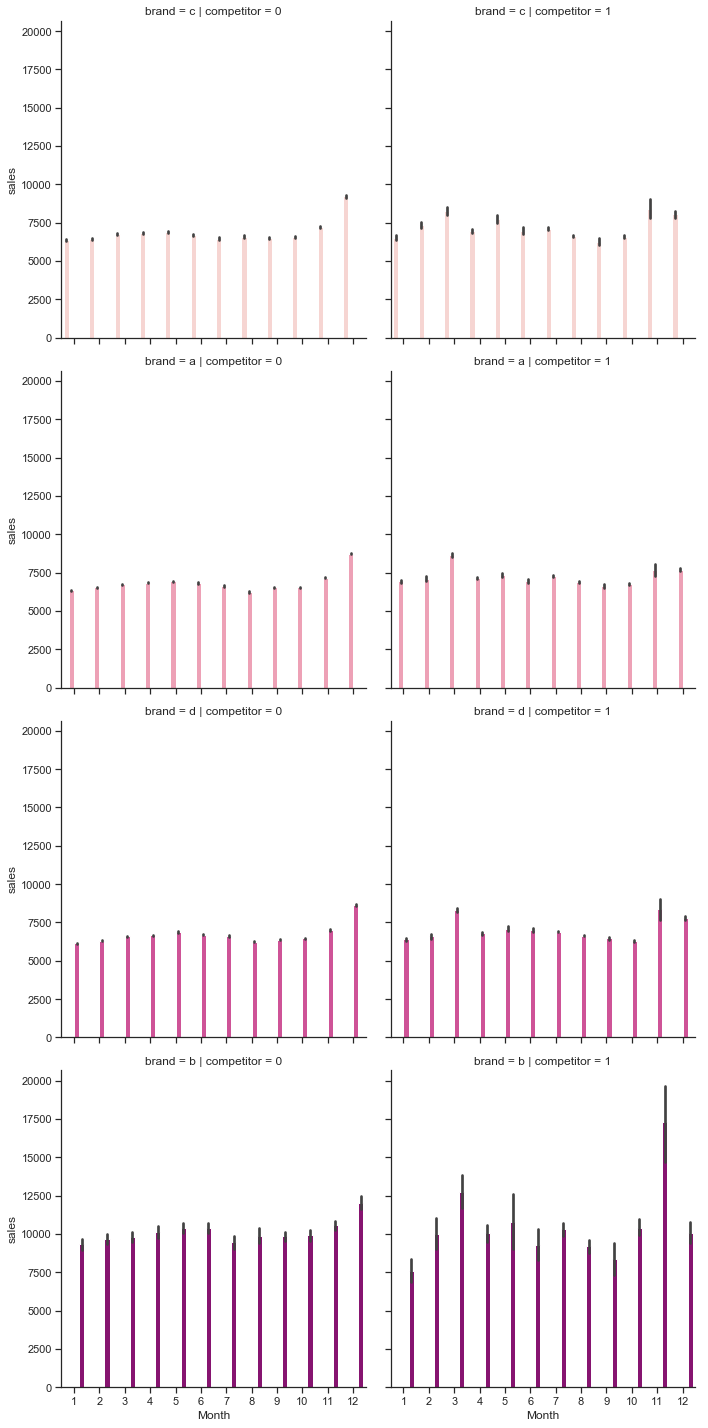

In [71]:
sns.catplot(data = train, x = 'Month', y = "sales", 
               col = "competitor",
               palette = 'RdPu',
               hue = 'brand',
               row = 'brand',
            kind="bar",
               color = c)

The data here shows us that whether the competitor is open or not has influence on sale revenue. When the competitor is open (competitor = 0) then we have a normal activity but when competitor is closed (competitor = 1) then we have a spike regarding the sale revenue.

<h2>EDA CONCLUSION</h2>
<br>
<br>
The most selling brand is A.
<br>
<br>
The best "sale per customer" brand is D, it indicates on average that the brand sells more expensive items.
<br>
<br>
Low sale per customer amount for brand B indicates that people going to this brand may have lower income. Eventhough this brand generated the least amount of sales and customers over the whole period, it shows a great potential.
<br>
<br>
Customers tends to buy more on Mondays when there's one discount (discount) and on Sundays when there's no discount at all (both discount and marketing campaign are equal to 0).
<br>
<br>
Marketing campaign alone doesn't seem to be correlated to any significant change in the sales amount.

<h2>Time-Series Analysis per Brand</h2>
<br>
<br>
What makes a time series different from a regular regression problem?
<br>
<br>
It is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case.<br>
Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.<br>
We build a time series analysis on brands. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonalities in the dataset.
<br>
<br>
In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model but it won't be our main focus today. Instead, we try to understand the data, and only later come up with the forecasts using Prophet methodology.

<h3>Seasonality</h3>
We take our four brands and we downsample the data from days to weeks using the resample method to see the present trends more clearly.

In [28]:
# preparation: input should be float type
train['sales'] = train['sales'] * 1.0

# brands
sales_a = train[train.brand == "a"]['sales']
sales_b = train[train.brand == "b"]['sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.brand == "c"]['sales']
sales_d = train[train.brand == "d"]['sales']

# brands
sales_a = sales_a.resample('W').sum()
sales_b = sales_b.resample('W').sum()
sales_c = sales_c.resample('W').sum()
sales_d = sales_d.resample('W').sum()

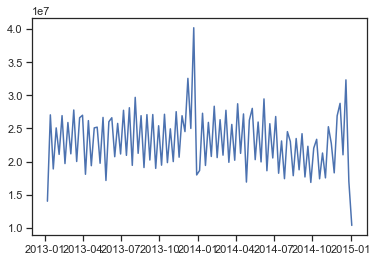

In [29]:
plt.plot(sales_a.index, sales_a.values)

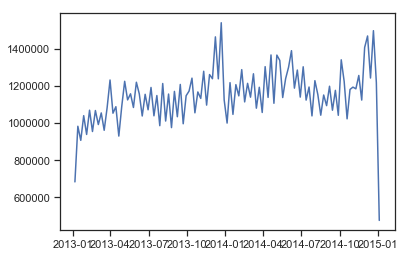

In [30]:
plt.plot(sales_b.index, sales_b.values)

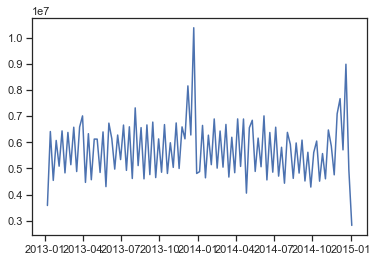

In [31]:
plt.plot(sales_c.index, sales_c.values)

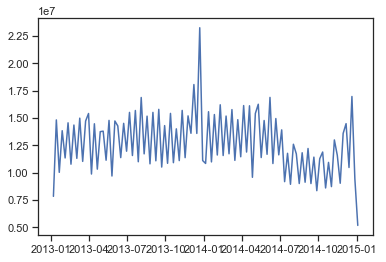

In [32]:
plt.plot(sales_d.index, sales_d.values)

Retail sales for brands A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for brand D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as they were closed.

<h3>Yearly trend</h3>
The next thing to check the presence of a trend in series.

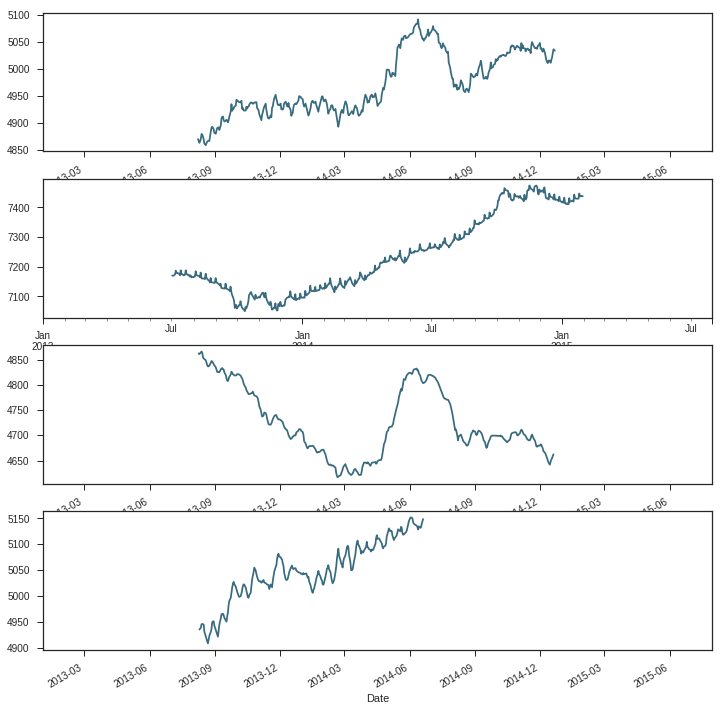

Overall sale revenue seems to increase, however not for the brand C (a third from the top). Eventhough the brand A is the most selling brand in the dataset, it seems that it cab follow the same decresing trajectory as brand C did.

<h3>Autocorrelaion</h3>
<br>
The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.
<br>
<br>
ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).
<br>
<br>
PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

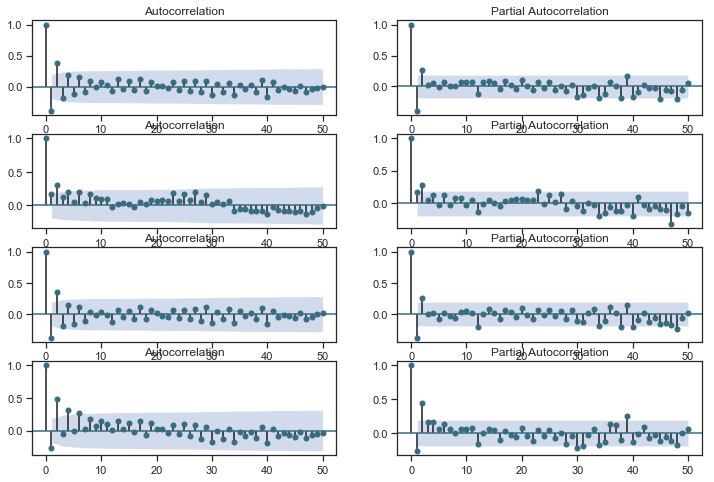

In [33]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

<h3>Time Series Analysis and Forecasting with Prophet</h3>

In [34]:
# importing data
df = pd.read_csv("god.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["store_status"] != 0) & (df['sales'] != 0)]

# sales for the brand A
salesa = df[df.brand == "a"].loc[:, ['date', 'sales']]
salesb = df[df.brand == "b"].loc[:, ['date', 'sales']]
salesc = df[df.brand == "c"].loc[:, ['date', 'sales']]
salesd = df[df.brand == "d"].loc[:, ['date', 'sales']]

# reverse to the order: from 2013 to 2015
salesa = salesa.sort_index(ascending = False)
salesb = salesb.sort_index(ascending = False)
salesc = salesc.sort_index(ascending = False)
salesd = salesd.sort_index(ascending = False)

# to datetime64
salesa['date'] = pd.DatetimeIndex(salesa['date'])
salesb['date'] = pd.DatetimeIndex(salesb['date'])
salesc['date'] = pd.DatetimeIndex(salesc['date'])
salesd['date'] = pd.DatetimeIndex(salesd['date'])

In [35]:
# from the prophet documentation every variables should have specific names
salesa = salesa.rename(columns = {'date': 'ds',
                                'sales': 'y'})
salesb = salesb.rename(columns = {'date': 'ds',
                                'sales': 'y'})
salesc = salesc.rename(columns = {'date': 'ds',
                                'sales': 'y'})
salesd = salesd.rename(columns = {'date': 'ds',
                                'sales': 'y'})
salesb.head()

,ds,y
780810,2013-01-01,5961
780662,2013-01-01,4491
780483,2013-01-01,5035
780447,2013-01-01,10765
780396,2013-01-01,3375


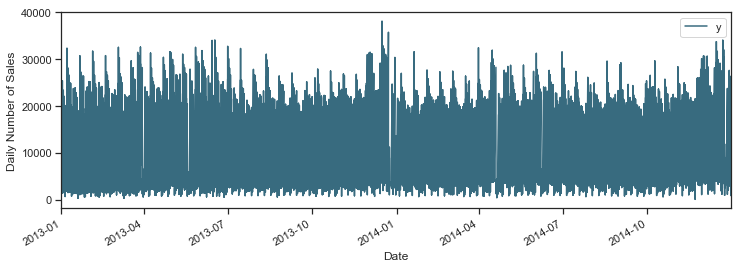

In [36]:
# plot daily sales
ax = salesa.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

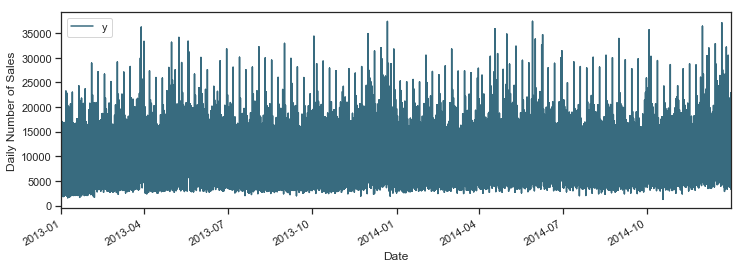

In [37]:
ax = salesb.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

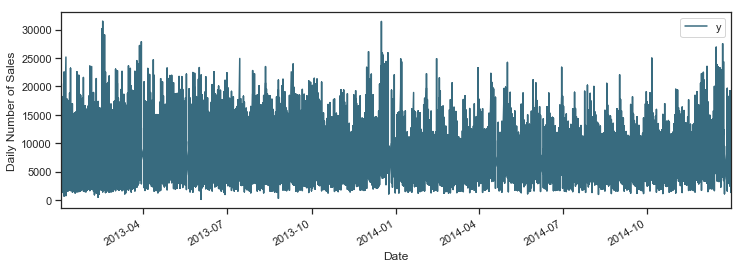

In [38]:
ax = salesc.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

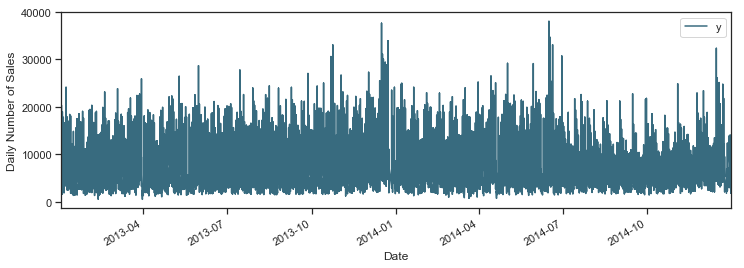

In [39]:
ax = salesd.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [40]:
# create holidays dataframe
state_dates = df[(df.holiday == 'a') | (df.holiday == 'b') & (df.holiday == 'c')].loc[:, 'date'].values
competitor_open = df[df.competitor == 1].loc[:, 'date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
competitor = pd.DataFrame({'holiday': 'competitor_holiday',
                      'ds': pd.to_datetime(competitor_open)})

holidays = pd.concat((state, competitor))      
holidays.head()

,holiday,ds
0,state_holiday,2014-11-01
1,state_holiday,2014-11-01
2,state_holiday,2014-11-01
3,state_holiday,2014-11-01
4,state_holiday,2014-11-01


In [42]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_modela = Prophet(interval_width = 0.95, 
                   holidays = holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
my_modela.fit(salesa)

my_modelb = Prophet(interval_width = 0.95, 
                   holidays = holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
my_modelb.fit(salesb)

my_modelc = Prophet(interval_width = 0.95, 
                   holidays = holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
my_modelc.fit(salesc)

my_modeld = Prophet(interval_width = 0.95, 
                   holidays = holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
my_modeld.fit(salesd)

# dataframe that extends into future 6 weeks 
future_datesa = my_modela.make_future_dataframe(periods = 52*7)
future_datesb = my_modelb.make_future_dataframe(periods = 52*7)
future_datesc = my_modelc.make_future_dataframe(periods = 52*7)
future_datesd = my_modeld.make_future_dataframe(periods = 52*7)

In [43]:
# predictions
forecasta = my_modela.predict(future_datesa)
forecastb = my_modelb.predict(future_datesb)
forecastc = my_modelc.predict(future_datesc)
forecastd = my_modeld.predict(future_datesd)

In [44]:
fca = forecasta[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
fcb = forecastb[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
fcc = forecastc[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
fcd = forecastd[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

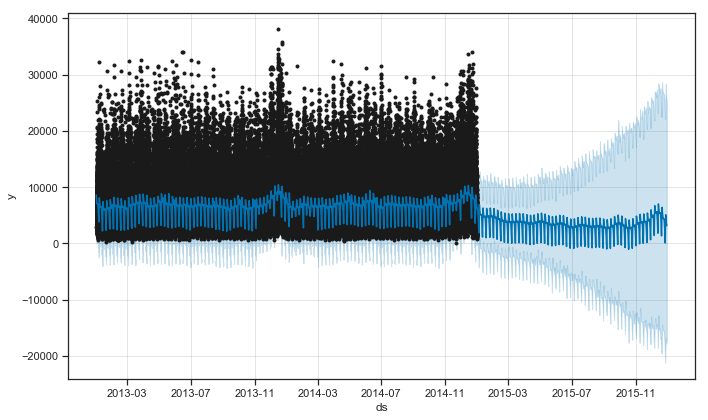

In [45]:
# visualizing predicions
my_modela.plot(forecasta);

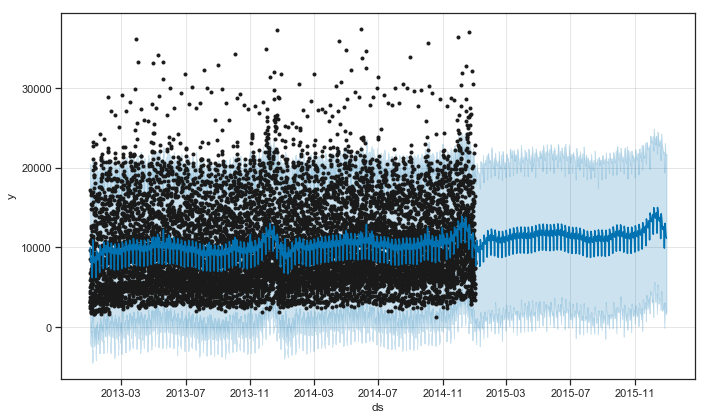

In [46]:
my_modelb.plot(forecastb);

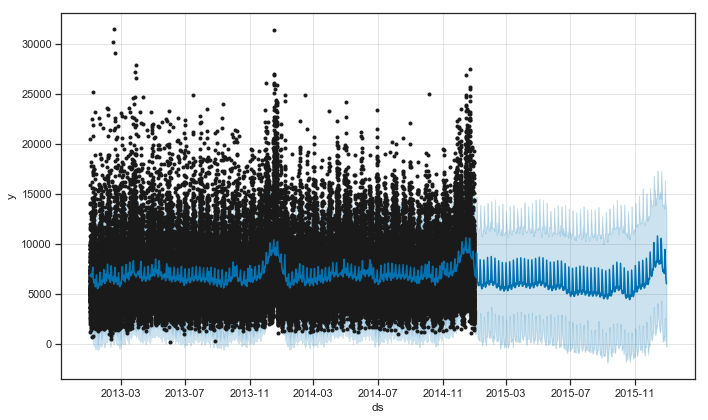

In [47]:
my_modelc.plot(forecastc);

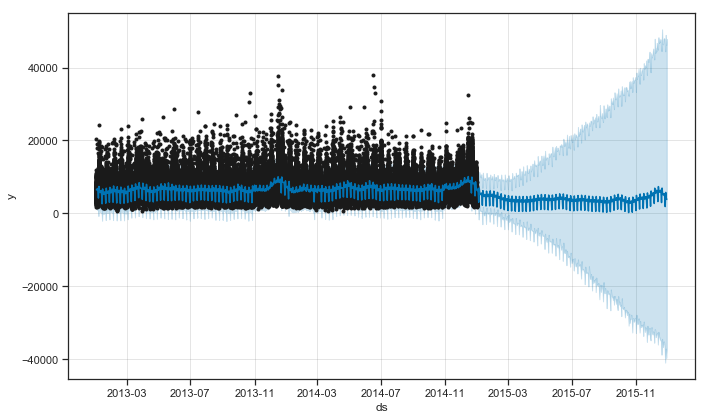

In [48]:
my_modeld.plot(forecastd);

As we see Prophet catches the trends and most of the time gets future values right (except for brand A).

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manually included holidayes contribute to the overall forecasted values:

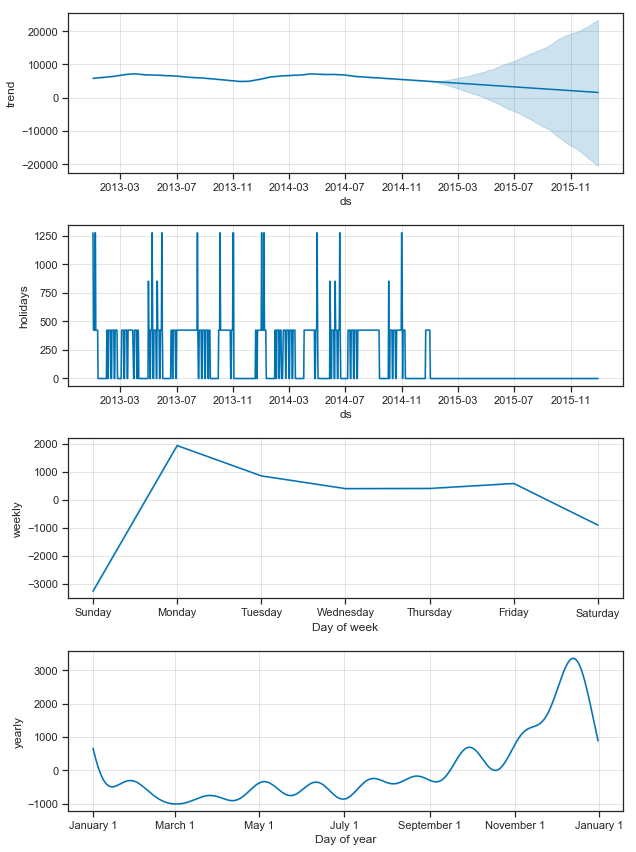

In [49]:
my_modela.plot_components(forecasta);

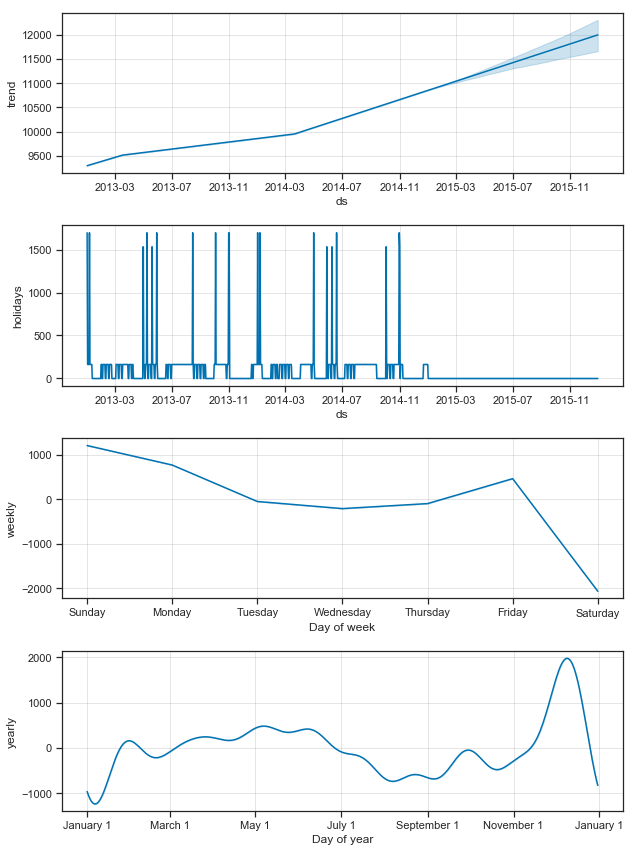

In [50]:
my_modelb.plot_components(forecastb);

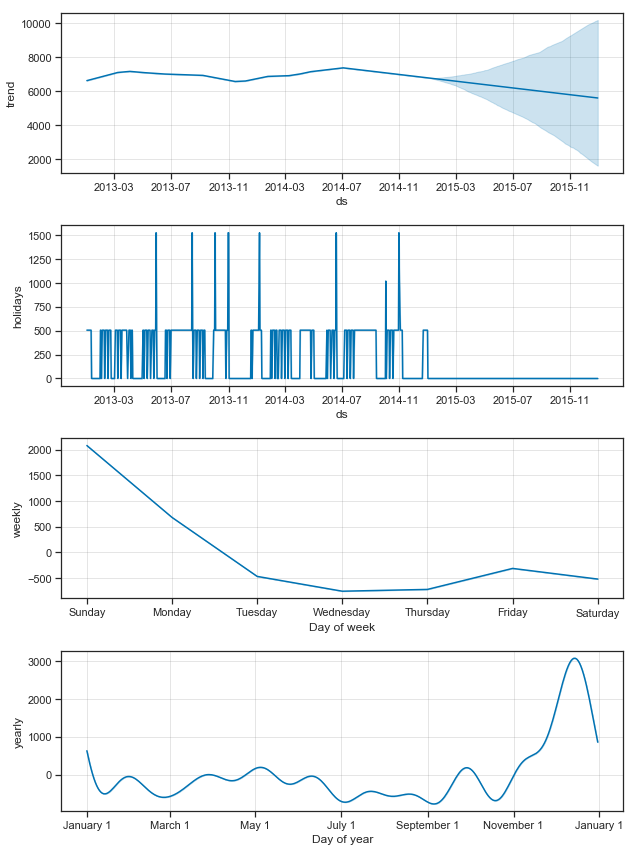

In [51]:
my_modelc.plot_components(forecastc);

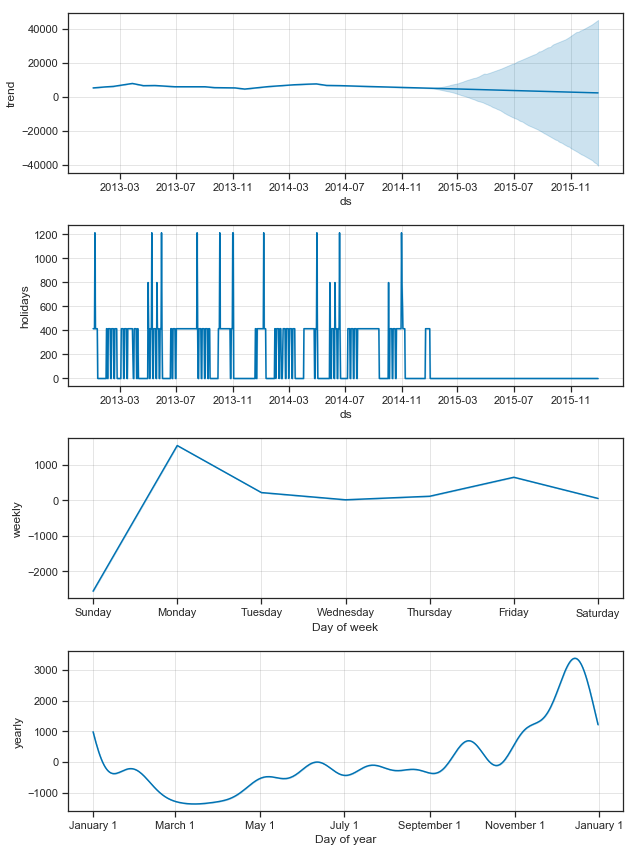

In [52]:
my_modeld.plot_components(forecastd);

The first plot shows that the monthly sale revenue of brand A has been linearly decreasing over time and the second shows the holidays gaps included in the model. The third plot shows the activity of brands during the week. The most selling day are either Sunday if the brand opens on Sunday either Monday if it does not. The fourth plot shows that the most buzy season occurs during the Christmas holidays.

<h2>Conclusion of Time Series forecasting</h2>
<br>
<br>
During this part, we discussed time series analysis with .seasonal_decompose(), ACF and PCF plots and fitted forecasting model using a new procedure by Facebook Prophet.
<br>
We can now present main advantages and drawbacks of time series forecasting:
<br>
<h3>Advantages</h3>
<br>
A powerful tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manually).
<br>
Easily implemented with R auto.arima() from forecast package, which runs a complex grid search and sophisticated algorithm behind the scene.
<br>
<h3>Drawbacks</h3>
<br>
<br>
Doesn't catch interactions between external features, which could improve the forecasting power of a model. In our case, these variables are discount and CompetitionOpen.
<br>
Even though Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
<br>
Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the biggest drawback for new companies.
<br>
Seasonal ARIMA in Python has 7 hyper parameters which can be tuned only manually affecting significantly the speed of the forecasting process.

<h2>Sample from above analysis (clearer)</h2>

In [53]:
# importing data
df = pd.read_csv("god.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["store_status"] != 0) & (df['sales'] != 0)]

# sales for the brand A
salessamplea = df[df.store_id == 2].loc[:, ['date', 'sales']]
salessampleb = df[df.store_id == 259].loc[:, ['date', 'sales']]
salessamplec = df[df.store_id == 1].loc[:, ['date', 'sales']]
salessampled = df[df.store_id == 15].loc[:, ['date', 'sales']]

# reverse to the order: from 2013 to 2015
salessamplea = salessamplea.sort_index(ascending = False)
salessampleb = salessampleb.sort_index(ascending = False)
salessamplec = salessamplec.sort_index(ascending = False)
salessampled = salessampled.sort_index(ascending = False)

# to datetime64
salessamplea['date'] = pd.DatetimeIndex(salessamplea['date'])
salessampleb['date'] = pd.DatetimeIndex(salessampleb['date'])
salessamplec['date'] = pd.DatetimeIndex(salessamplec['date'])
salessampled['date'] = pd.DatetimeIndex(salessampled['date'])

In [54]:
# from the prophet documentation every variables should have specific names
salessamplea = salessamplea.rename(columns = {'date': 'ds',
                                'sales': 'y'})
salessampleb = salessampleb.rename(columns = {'date': 'ds',
                                'sales': 'y'})
salessamplec = salessamplec.rename(columns = {'date': 'ds',
                                'sales': 'y'})
salessampled = salessampled.rename(columns = {'date': 'ds',
                                'sales': 'y'})

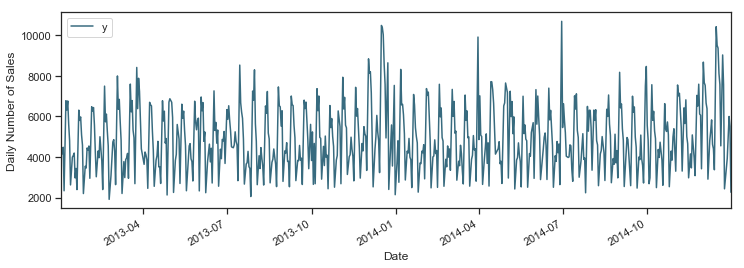

In [55]:
# plot daily sales
ax = salessamplea.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

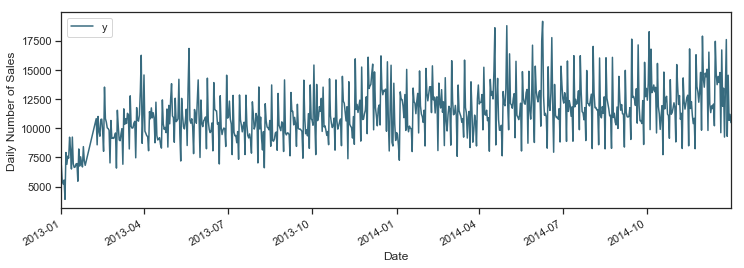

In [56]:
# plot daily sales
ax = salessampleb.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

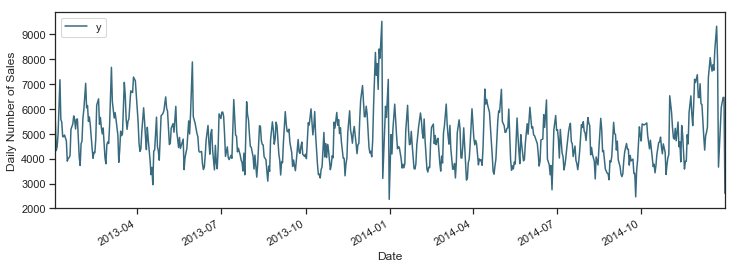

In [57]:
# plot daily sales
ax = salessamplec.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

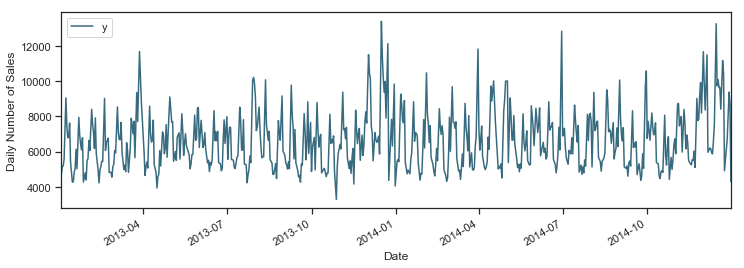

In [58]:
# plot daily sales
ax = salessampled.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [59]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_modela = Prophet(interval_width = 0.95, 
                   holidays = holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
my_modela.fit(salessamplea)

my_modelb = Prophet(interval_width = 0.95, 
                   holidays = holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
my_modelb.fit(salessampleb)

my_modelc = Prophet(interval_width = 0.95, 
                   holidays = holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
my_modelc.fit(salessamplec)

my_modeld = Prophet(interval_width = 0.95, 
                   holidays = holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
my_modeld.fit(salessampled)

# dataframe that extends into future 6 weeks 
future_datessamplea = my_modela.make_future_dataframe(periods = 52*7)
future_datessampleb = my_modelb.make_future_dataframe(periods = 52*7)
future_datessamplec = my_modelc.make_future_dataframe(periods = 52*7)
future_datessampled = my_modeld.make_future_dataframe(periods = 52*7)

In [60]:
# predictions
forecastsamplea = my_modela.predict(future_datessamplea)
forecastsampleb = my_modelb.predict(future_datessampleb)
forecastsamplec = my_modelc.predict(future_datessamplec)
forecastsampled = my_modeld.predict(future_datessampled)

In [61]:
fcsamplea = forecastsamplea[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
fcsampleb = forecastsampleb[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
fcsamplec = forecastsamplec[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
fcsampled = forecastsampled[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

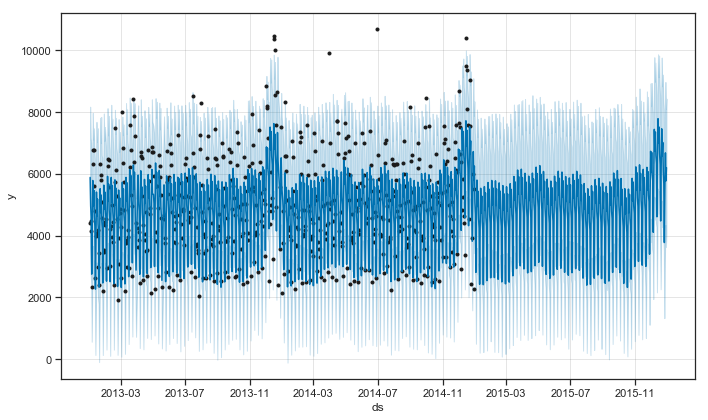

In [62]:
# visualizing predicions
my_modela.plot(forecastsamplea);

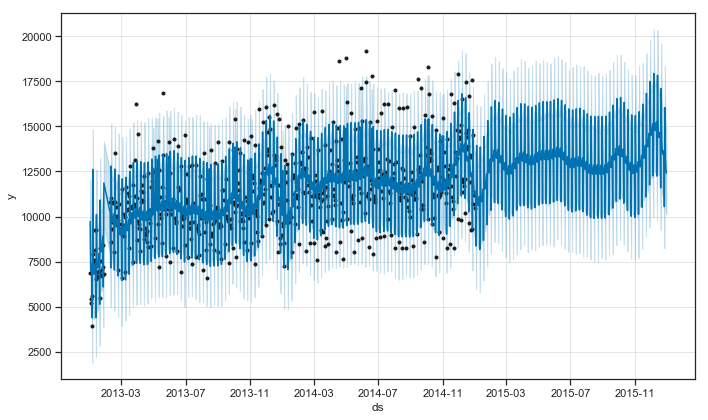

In [63]:
# visualizing predicions
my_modelb.plot(forecastsampleb);

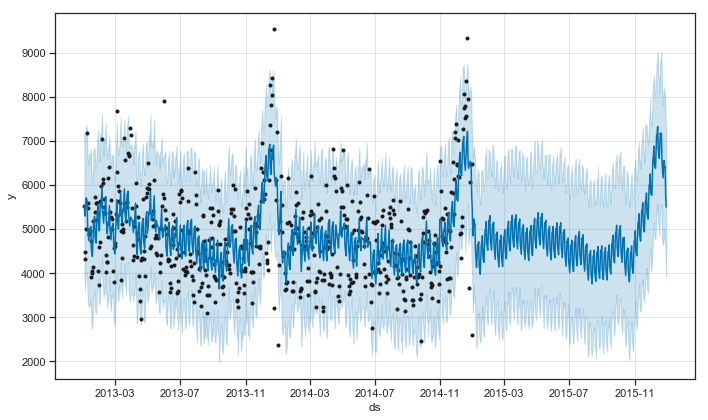

In [64]:
# visualizing predicions
my_modelc.plot(forecastsamplec);

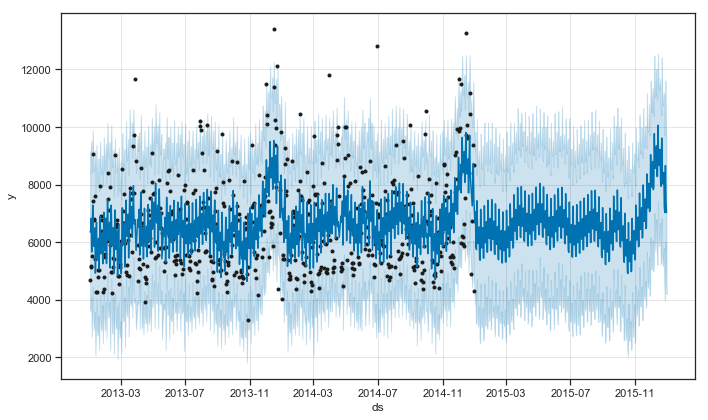

In [65]:
# visualizing predicions
my_modeld.plot(forecastsampled);

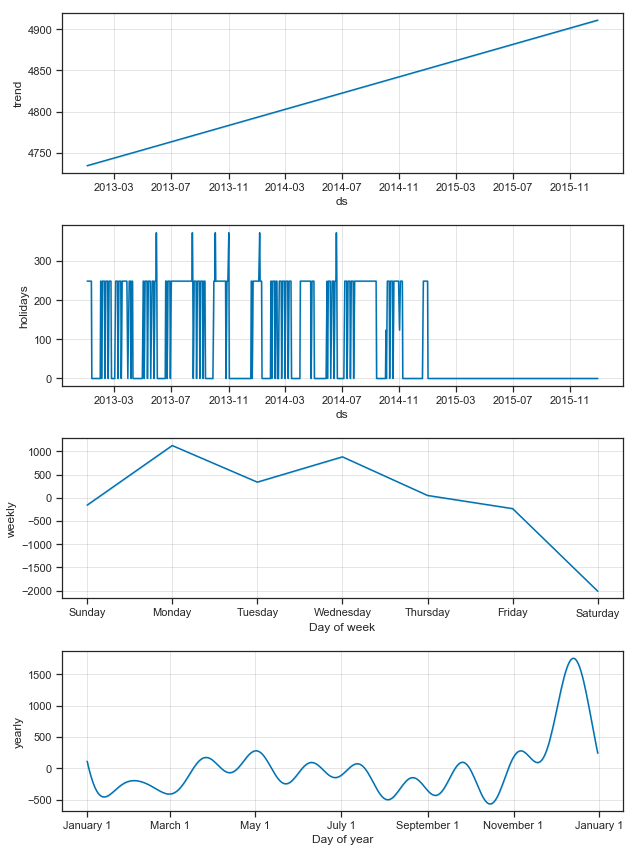

In [66]:
my_modela.plot_components(forecastsamplea);

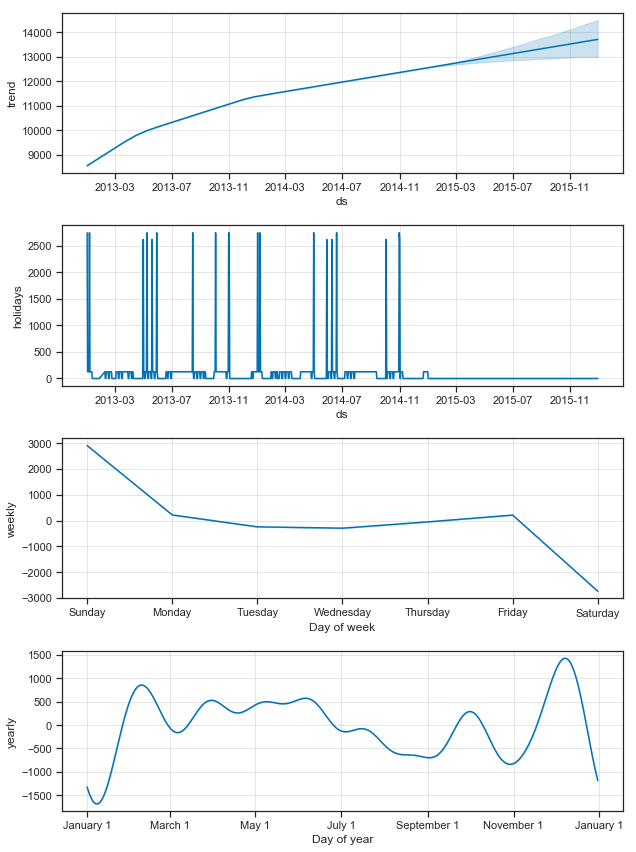

In [67]:
my_modelb.plot_components(forecastsampleb);

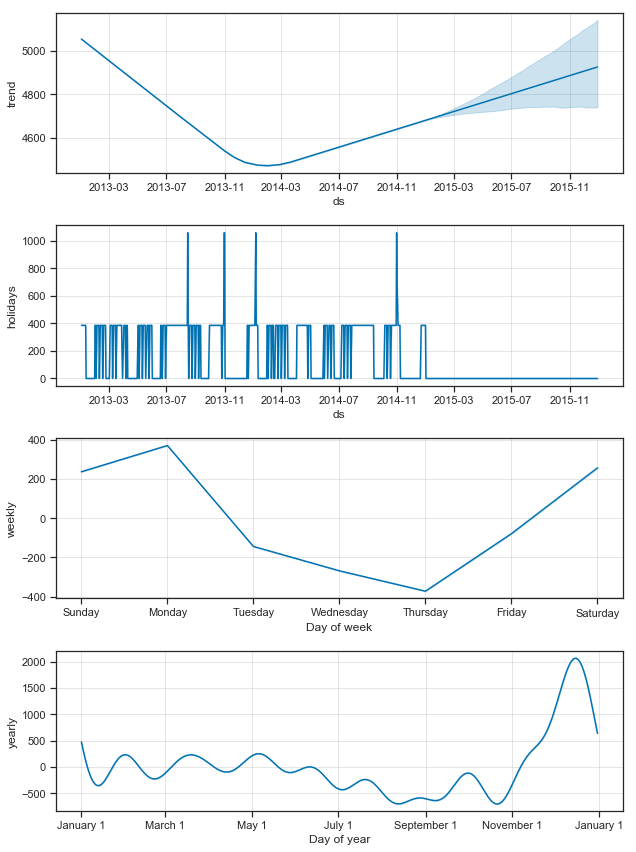

In [68]:
my_modelc.plot_components(forecastsamplec);

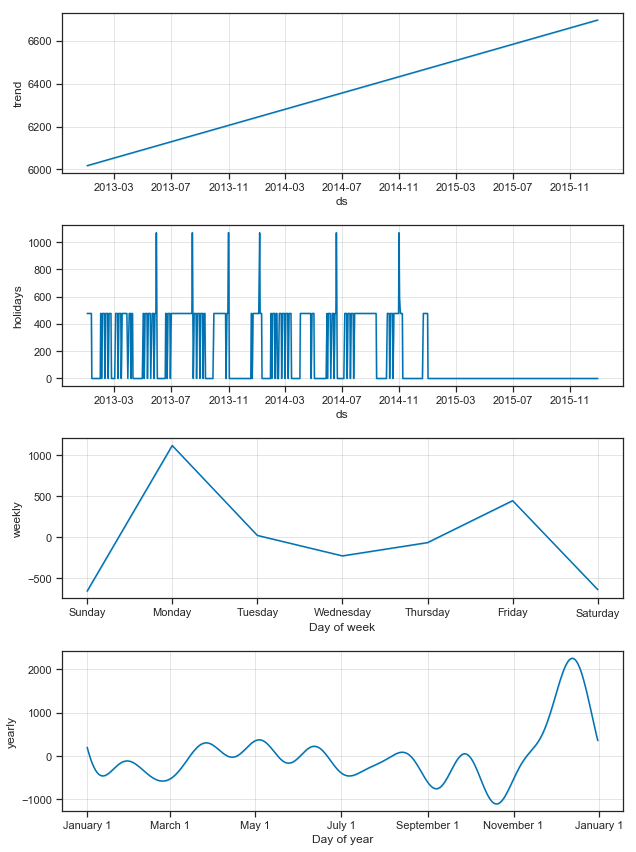

In [69]:
my_modeld.plot_components(forecastsampled);